# Preparation

In [76]:
# Import statements
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, MaxPooling1D, Conv1D, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from itertools import chain
import tensorflow as tf

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator


In [2]:
pose_estimator = YOLO('yolov8n-pose.pt')

In [3]:
IMAGE_DIR = 'newImages'

# Data Generation and Preprocessing

In [7]:
arr = []

In [8]:

def crop_video_per_person(vid_path, classes):    # Saving path for frames 
    SAVING_PATH = max([int(folder) for folder in os.listdir(IMAGE_DIR)]) + 1 if len(os.listdir(IMAGE_DIR)) != 0 else 0
    SAVING_PATH = os.path.join(IMAGE_DIR, str(SAVING_PATH))
    os.mkdir(SAVING_PATH)
    

    # Load Video
    vid = cv2.VideoCapture(vid_path)
    i = 0
    while True:
        i += 1
        ret, frame = vid.read()
        if not ret:
            break
        
        # Predict
        results = pose_estimator.predict(frame, conf = 0.70)
        

        annotator = Annotator(frame)
        
        
        # Create directory for each person
        person_save = os.path.join(SAVING_PATH, '0')
        try:
            os.mkdir(person_save)
        except FileExistsError:
            pass
        if len(results[0].boxes) >= 1 and i % 10 == 0:
            box = results[0].boxes[0]
            box = box.xyxy[0]
            # annotator.box_label(box, 'Working')
            x1, y1, x2, y2 = box
            # Preprocess for the training data
            points = results[0].keypoints.xy[0]
            temp = [[max(i-x1, 0), max(0, j-y1)] for i, j in points]
            temp = list(map(float, list(chain(*temp))))
            print(temp + [classes])
            arr.append(temp + [classes])
            new_frame = results[0].plot()
            # Crop the frame
            x1, y1, x2, y2 = map(int, box)
            cropped_frame = new_frame[max(0, y1-10):y2+10 , max(0, x1- 10):x2+10]
            
            
            cropped_frame = cv2.resize(cropped_frame, (380, 640))
            cv2.imwrite(os.path.join(person_save, f'{i}.jpg'), cropped_frame)


        # frame = annotator.result()
        frame = annotator.result()
        cv2.imshow('Test', frame)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    vid.release()
    cv2.destroyAllWindows()


for idx, folder in enumerate(os.listdir('videos')):
    for file in os.listdir(f'videos/{folder}'):
        path = f'videos/{folder}/{file}'
        crop_video_per_person(path, idx)



0: 384x640 1 person, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 99.0ms
Speed: 4.0ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.0ms
Speed: 3.0ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 72.0ms
Speed: 3.0ms preprocess, 72.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 73.0ms
Speed: 3.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.0ms
Speed: 4.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 78.0ms
Speed: 4.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 38

In [27]:
df = pd.DataFrame(arr)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,148.210449,79.982086,169.165039,62.861725,128.325256,63.547638,202.008179,81.061768,102.639954,82.000320,...,509.196350,210.209961,723.451294,99.467590,721.437439,199.947266,923.172485,107.654785,922.562134,0
1,148.052551,79.984589,169.257202,63.138611,128.620850,63.435837,201.631958,81.441467,102.879822,81.345749,...,510.858887,207.064941,723.034302,97.219849,722.024109,195.608276,915.765381,106.981750,916.649048,0
2,152.538818,78.767975,173.645386,61.837814,132.786316,62.447968,206.577393,80.578888,107.439941,81.404877,...,510.142273,211.194946,724.960327,101.649597,721.225281,199.661255,919.832092,111.519714,915.661316,0
3,150.107666,77.602234,170.922791,60.504028,129.468933,61.823303,204.003052,79.572174,103.137634,82.215988,...,510.454346,210.376221,725.420959,101.081421,722.735901,198.112793,920.997253,109.720825,917.019226,0
4,147.895691,75.801086,168.082764,58.296295,126.583313,60.751648,201.273315,77.213379,100.549194,82.684204,...,509.139526,211.097656,722.139221,102.420776,721.215149,199.090698,916.228455,108.685120,913.328979,0


In [28]:
last_idx = df.columns[-1]

In [11]:

# # Define a function to sample rows for each group
# def balanced_sample(group):
#     return group.sample(min(1000, len(group)))

# # Apply the function to each group
# balanced_df = df.groupby(last_idx, group_keys=False).apply(balanced_sample)

# # Reset index to have a clean DataFrame with balanced samples
# balanced_df.reset_index(drop=True, inplace=True)

# balanced_df[last_idx].value_counts()


C:\Users\manol\AppData\Local\Temp\ipykernel_17108\3725657637.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(last_idx, group_keys=False).apply(balanced_sample)


34
0    701
1    630
Name: count, dtype: int64

In [29]:
X = df.iloc[:, :-1]  # Select all columns except the last one
y = df.iloc[:, -1] 

In [31]:
import numpy as np

def create_sequences(data, lookback):
    sequences = []
    for i in range(len(data) - lookback + 1):
        sequences.append(data[i:i + lookback])
    return np.array(sequences)

# Convert DataFrame to numpy array
# data = df.drop(columns=['frame']).values

# Create sequences with 10 lookbacks
lookback = 10
sequences = create_sequences(X, lookback)

# Verify shape of sequences
print(sequences.shape)  # Should be (num_samples, 10, num_features)


(1322, 10, 34)


In [32]:
# Assuming `labels` contains the target labels for each frame # Replace with actual labels

# Align labels with sequences
aligned_labels = y[lookback - 1:]

# Split the sequences and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, aligned_labels, test_size=0.2, random_state=42)

In [33]:
# Flatten sequences for scaling
scaler = MinMaxScaler()
num_samples, num_timesteps, num_features = X_train.shape
X_train_flat = X_train.reshape(-1, num_features)
X_test_flat = X_test.reshape(-1, num_features)

# Fit scaler on training data and transform both training and testing data
scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(num_samples, num_timesteps, num_features)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape[0], num_timesteps, num_features)


In [128]:
y = to_categorical(y)

In [14]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size = 0.2, random_state = 9999, shuffle= False)

In [16]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,148.210449,79.982086,169.165039,62.861725,128.325256,63.547638,202.008179,81.061768,102.639954,82.000320,...,96.146973,509.196350,210.209961,723.451294,99.467590,721.437439,199.947266,923.172485,107.654785,922.562134
1,148.052551,79.984589,169.257202,63.138611,128.620850,63.435837,201.631958,81.441467,102.879822,81.345749,...,94.687561,510.858887,207.064941,723.034302,97.219849,722.024109,195.608276,915.765381,106.981750,916.649048
2,152.538818,78.767975,173.645386,61.837814,132.786316,62.447968,206.577393,80.578888,107.439941,81.404877,...,99.494934,510.142273,211.194946,724.960327,101.649597,721.225281,199.661255,919.832092,111.519714,915.661316
3,150.107666,77.602234,170.922791,60.504028,129.468933,61.823303,204.003052,79.572174,103.137634,82.215988,...,98.992493,510.454346,210.376221,725.420959,101.081421,722.735901,198.112793,920.997253,109.720825,917.019226
4,147.895691,75.801086,168.082764,58.296295,126.583313,60.751648,201.273315,77.213379,100.549194,82.684204,...,98.202148,509.139526,211.097656,722.139221,102.420776,721.215149,199.090698,916.228455,108.685120,913.328979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.925461,217.704483,214.896774,78.101379,145.132401,117.596863,176.615219,301.803345,145.967911,359.960144
1117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,38.378250,294.562927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,307.766113,104.248779,140.046646,114.059113,181.649017,318.892151,65.543991,359.305481
1119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,256.834930,63.508453,69.608093,100.384216,178.195679,326.187012,27.710663,412.407043


# HAAR Model Creation

In [75]:
# from keras.callbacks import EarlyStopping
# LSTM_model = Sequential()
# LSTM_model.add(Dense(256, input_shape=(34,), activation='relu'))
# LSTM_model.add(Dropout(0.25))  # Add dropout for regularization
# LSTM_model.add(Dense(128, activation='relu'))  # Add another dense layer
# LSTM_model.add(Dense(64, activation='relu'))
# LSTM_model.add(Dense(32, activation='relu'))
# LSTM_model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# # Train the model with early stopping
# history = LSTM_model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks =early_stopping)

In [52]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(10, 34)))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
LSTM_model.add(LSTM(64, activation='relu', return_sequences=False))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
LSTM_model.add(Dense(64, activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
LSTM_model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model with early stopping
LSTM_history = LSTM_model.fit(X_train_scaled, y_train, epochs=500, batch_size=64, validation_data=(X_test_scaled, y_test), callbacks =early_stopping)

Epoch 1/500


c:\Users\manol\.conda\envs\experiment\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7778 - loss: 0.4396 - val_accuracy: 0.7321 - val_loss: 0.6686
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9506 - loss: 0.1527 - val_accuracy: 0.7321 - val_loss: 0.6429
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9758 - loss: 0.0937 - val_accuracy: 0.6981 - val_loss: 0.6190
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9877 - loss: 0.0534 - val_accuracy: 0.8642 - val_loss: 0.5831
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9949 - loss: 0.0327 - val_accuracy: 0.9811 - val_loss: 0.5558
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0285 - val_accuracy: 0.9849 - val_loss: 0.5234
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9991 - loss: 0.0178 - val_accuracy: 0.9774 - val_loss: 0.4668
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0279 - val_accuracy: 0.9849 - val_loss: 0.

In [53]:
LSTM_history = LSTM_history.history

In [54]:
def plotHist(history):    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

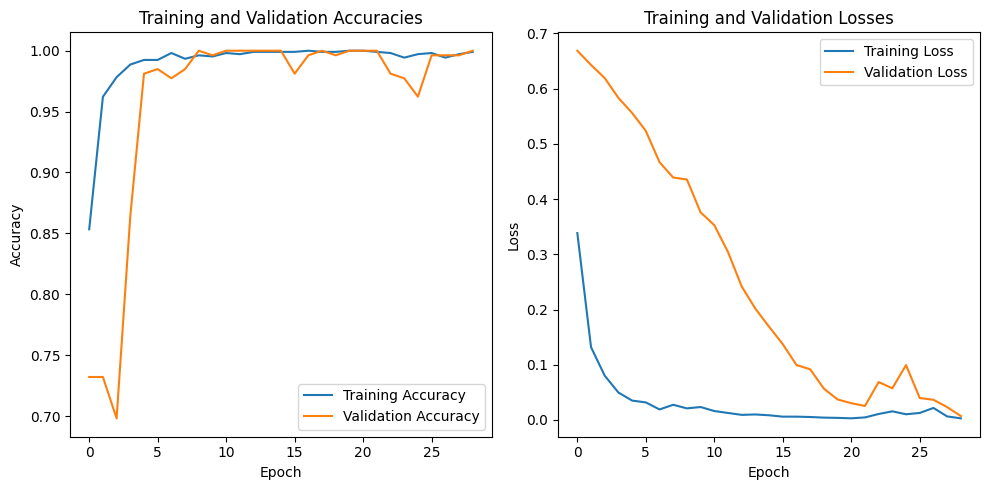

In [55]:
plotHist(LSTM_history)

In [44]:
# Predict probabilities on the test set
y_pred_prob = LSTM_model.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [45]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

# Optionally, print a classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[151   0]
 [  0 114]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00       114

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265



In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

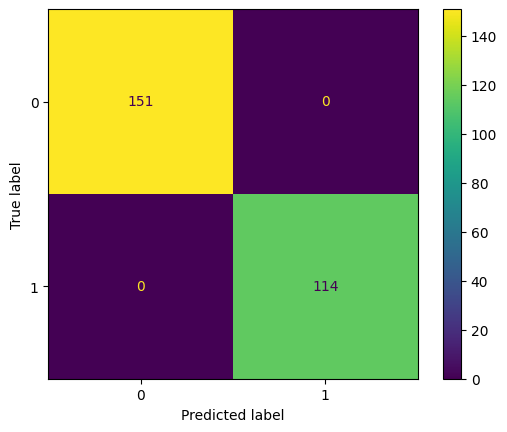

In [48]:
disp.plot()

In [66]:
CNN1D = Sequential()
CNN1D.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10, 34)))
CNN1D.add(MaxPooling1D(pool_size=2))
CNN1D.add(Dropout(0.5))

CNN1D.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN1D.add(MaxPooling1D(pool_size=2))
CNN1D.add(Dropout(0.5))

CNN1D.add(Flatten())
CNN1D.add(Dense(units=64, activation='relu'))
CNN1D.add(Dropout(0.5))
CNN1D.add(Dense(units=1, activation='sigmoid'))  # Binary classification (working or not working)


c:\Users\manol\.conda\envs\experiment\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
CNN1D.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [68]:
CNN1D_hist = CNN1D.fit(X_train_scaled, y_train, epochs=500, batch_size=64, validation_data=(X_test_scaled, y_test), callbacks =early_stopping)

Epoch 1/500


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5521 - loss: 0.6703 - val_accuracy: 0.9472 - val_loss: 0.5612
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7697 - loss: 0.5319 - val_accuracy: 0.9509 - val_loss: 0.3569
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8843 - loss: 0.3605 - val_accuracy: 0.9585 - val_loss: 0.2119
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9068 - loss: 0.2437 - val_accuracy: 0.9849 - val_loss: 0.1239
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9669 - loss: 0.1414 - val_accuracy: 0.9849 - val_loss: 0.0715
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9690 - loss: 0.1172 - val_accuracy: 0.9962 - val_loss: 0.0514
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9660 - loss: 0.1007 - val_accuracy: 0.9962 - val_loss: 0.0397
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9853 - loss: 0.0653 - val_accuracy: 0.9962 - val_loss: 0.

In [69]:
# Predict probabilities on the test set
CNN1D_y_pred_prob = CNN1D.predict(X_test_scaled)

# Convert probabilities to binary predictions
CNN1D_y_pred = (CNN1D_y_pred_prob > 0.5).astype(int)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [70]:
# Calculate the confusion matrix
CNN1D_conf_matrix = confusion_matrix(y_test, CNN1D_y_pred)

# Print confusion matrix
print('Confusion Matrix:')
print(CNN1D_conf_matrix)

# Optionally, print a classification report
print('Classification Report:')
print(classification_report(y_test, CNN1D_y_pred))


Confusion Matrix:
[[150   1]
 [ 13 101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       151
           1       0.99      0.89      0.94       114

    accuracy                           0.95       265
   macro avg       0.96      0.94      0.95       265
weighted avg       0.95      0.95      0.95       265



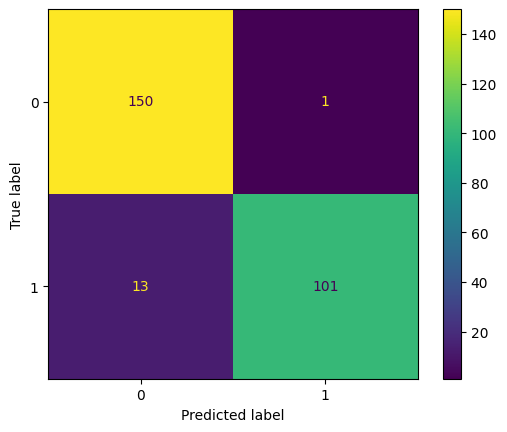

In [72]:
ConfusionMatrixDisplay(CNN1D_conf_matrix).plot()

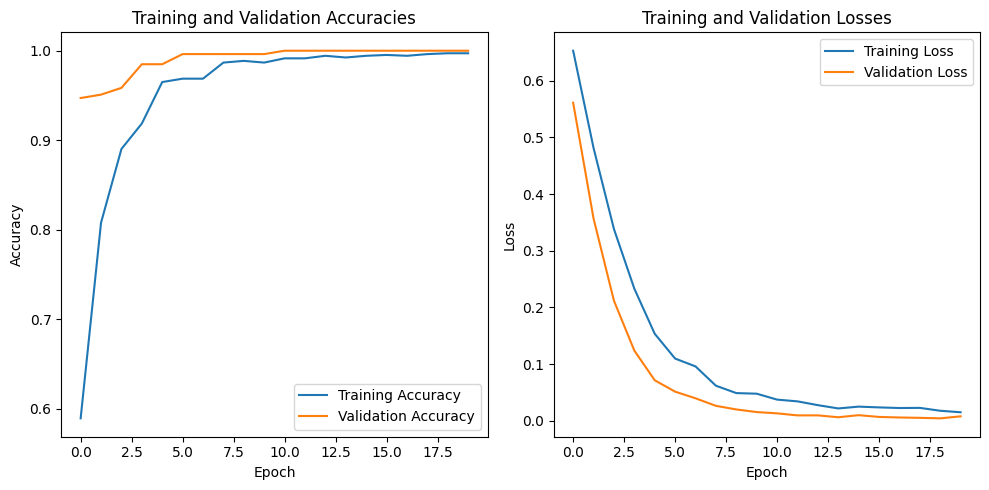

In [74]:
plotHist(CNN1D_hist.history)

# Save Progress

In [77]:
# balanced_df.to_csv('har_dataset.csv', index = False)
LSTM_model.save('LSTM_model.h5')
CNN1D.save('CNN1D_model.h5')

# Implementation

In [47]:
# PRED_MAP = {0: 'Brick Layering',
#              1: 'Idle Standing',
#              2: 'Idle Walking',
#              3: 'Transporting',
#              4: 'Mixing Cement'}

PRED_MAP = {0: 'Idle',
            1: 'Working'}

In [51]:
LSTM_model = load_model('haar_model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'haar_model.h5.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [52]:
def har_predict(input_data):
    # Reshape the input data to match the model's input shape
    input_data = input_data.reshape(1, -1)  # Reshape to (1, 34) or (1, -1) depending on the actual shape

    # Perform prediction
    prediction = LSTM_model.predict(input_data)
    res = prediction[0] >= 0.6
    return int(res)


def video_test(video_path):
    vid = cv2.VideoCapture(video_path)
    while True:
        ret, frame = vid.read()
        if not ret:
            break
        
        # Predict
        results = pose_estimator.predict(frame, conf = 0.70)
        annotator_frame = Annotator(frame)
        boxes = results[0].boxes
        for idx, box in enumerate(boxes.xyxy):
            x1, y1, x2, y2 = box

            # Preprocess keypoints to predict
            input_data = results[0].keypoints.xy[idx]
            input_data = [[max(i-x1, 0), max(0, j-y1)] for i, j in input_data]
            input_data = np.array(list(map(float, list(chain(*input_data)))))

            # Predict
            pred = har_predict(input_data)
            annotator_frame.box_label(box, PRED_MAP[pred])

        to_display = annotator_frame.result()
        cv2.imshow('Test', to_display)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    vid.release()
    cv2.destroyAllWindows()
        
            

In [53]:
video_test(r'videos\Not Working\Not Wokringasdf.mp4')


0: 640x352 1 person, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

0: 640x352 1 person, 79.0ms
Speed: 3.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



C:\Users\manol\AppData\Local\Temp\ipykernel_12064\3099448612.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(res)


0: 640x352 1 person, 75.0ms
Speed: 2.0ms preprocess, 75.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 640x352 1 person, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

0: 640x352 1 person, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 640x352 1 person, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

0: 640x352 1 person, 65.4ms
Speed: 1.0ms preprocess, 65.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 640x352 1 person, 64.1ms
Speed: 2.0ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

0: 640x352 1 per

# Testing

In [64]:
test_df = pd.read_csv('Untouched Working and Not Working Dataset.csv')
labels = test_df.columns[-1]

In [65]:
test_df[labels] = test_df[labels].apply(lambda x: 0 if x == 1 or x == 2 else 1)

In [66]:
test_df[labels].value_counts()

34
1    131
0    104
Name: count, dtype: int64

In [67]:
X = test_df.iloc[:, :-1]  # Select all columns except the last one
y = test_df.iloc[:, -1] 

In [68]:
temp = SMOTE(random_state= 44)
temp.fit_resample(X, y)

(              0           1           2           3           4           5  \
 0    357.203339  212.343994    0.000000    0.000000  355.637512  186.137939   
 1     61.490219  162.310974   68.205704  141.530334   47.419533  140.367645   
 2    264.311096  162.306519    0.000000    0.000000  256.781128  141.721008   
 3    230.917114  140.223511  242.737762  126.120270  223.563660  123.690399   
 4      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
 ..          ...         ...         ...         ...         ...         ...   
 257  289.147944  144.185779  321.913763  113.793351  255.930991  104.244902   
 258   73.004260  173.994252   80.830180  149.852882   49.107677  161.055686   
 259  200.482313  101.440409    0.000000    0.000000  201.172517   94.039302   
 260  240.080386  193.316800  263.699880  163.780237  183.508755  142.705386   
 261  191.988400  131.724497    0.000000    0.000000  192.741142  118.586957   
 
               6           7          

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 24, shuffle = True)

In [70]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
X_train = min_max.fit_transform(X_train)

In [71]:
from keras.callbacks import EarlyStopping
LSTM_model = Sequential()
LSTM_model.add(Dense(64, input_shape=(34,), activation='relu'))
LSTM_model.add(Dropout(0.5))  # Add dropout for regularization
LSTM_model.add(Dense(32, activation='relu'))  # Add another dense layer
LSTM_model.add(Dense(16, activation='relu'))
LSTM_model.add(Dense(8, activation='relu'))
LSTM_model.add(Dense(1, activation='sigmoid'))

# Compile the model
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks= early_stopping)

Epoch 1/100


c:\Users\manol\.conda\envs\experiment\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5224 - loss: 0.6996 - val_accuracy: 0.7458 - val_loss: 6.2100
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6644 - loss: 0.6775 - val_accuracy: 0.7288 - val_loss: 8.7232
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7063 - loss: 0.6628 - val_accuracy: 0.8136 - val_loss: 4.5826
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7314 - loss: 0.6602 - val_accuracy: 0.8983 - val_loss: 3.2536
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7637 - loss: 0.6301 - val_accuracy: 0.9322 - val_loss: 3.5322
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7985 - loss: 0.6205 - val_accuracy: 0.8983 - val_loss: 4.6031
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8436 - loss: 0.5894 - val_accuracy: 0.8814 - val_loss: 5.6326
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8285 - loss: 0.5940 - val_accuracy: 0.8814 - val_loss: 5.8839
Epoch 9/100